# Reproducible Segmentation of Not-Quite-Objects

![cilia](assets/normal_screenshot.png)

Source: http://dx.doi.org/10.1126/scitranslmed.aaa1233

## Object Segmentation

We want to segment objects!

Here "segmentation" means "draw a perfect line around the edges of the object" so we effectively have the coordinates in space of the object at any given time. 

![davis](http://davischallenge.org/images/teaser/2017/dogs-scale.jpg)

Source: http://davischallenge.org/images/teaser/2017/dogs-scale.jpg

## In particular...

We're interested in *cilia*: microscopic hairs that line the exteriors of every cell of your body.
 - throat
 - nose
 - lungs
 - kidneys
 - brain
 - ...

In [1]:
from IPython.display import Video
Video("assets/1_Normal.mov")

### When ciliary motion is compromised, all kinds of bad things happen

Abnormal / dyskinetic / diseased ciliary motion create *ciliopathies*, and they're tough to diagnose.

![diagnose](assets/diagnosis.png)

**Key takeaway: none of these are *quantitative*.**

But before we can even begin to ask how to quantify ciliary motion, we have to find it first--there's a lot of "not-cilia" areas in these videos!

### Big question: can we *automate* detection of cilia?

In effect: can we automatically segment the cilia out of videos?

This isn't your typical segmentation use-case: cilia aren't rigid objects!

Last year, we tried throwing a deep learning black box at the problem (known as *semantic segmentation*) which takes
 1. the image you want to segment
 2. a "ground-truth" mask that actually has the segmented regions

It worked... ok.
 - Top row: a still image of a video.
 - Middle row: hand-drawn segments (lighter shades of gray are cilia)
 - Bottom row: predicted segmentation

![diagnose](assets/deeplearning.png)

Source: https://arxiv.org/abs/1803.07534

Despite looking ok, there were a lot of drawbacks with this approach, chief among them:

**If we're all about automated and quantitative assessment of ciliary motion, why are we first requiring manually-determined segmentation labels?**

# Cilia Segmentation

In this notebook, we'll do some live coding to try and segment cilia out from three distinct videos!

...and basically illustrate why this is a hard problem that I'd love to have help with :)

In [2]:
# some preliminaries
%matplotlib notebook

from ipywidgets import interact  # Where the magic happens with ipywidgets.
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.linalg as sla
import scipy.signal as signal
import seaborn as sns            # This makes things look pretty.
from tqdm import tqdm            # Gives me a completion ticker in loops.

# Some custom helper functions.
from spq import widgets, evaluate, utils

## The Data

We have **three different videos**, creatively referred to as

#### Normal

This video has 250 frames, and is 256 pixels tall and 128 pixels wide.


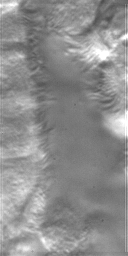

In [3]:
x1 = np.load("data/videos/normal.npy")
print("This video has {0} frames, and is {1} pixels tall and {2} pixels wide.".format(*x1.shape))
Image.fromarray(x1[0])

#### Wavy

This video has 136 frames, and is 256 pixels tall and 256 pixels wide.


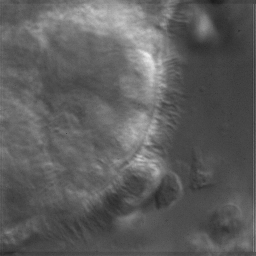

In [4]:
x2 = np.load("data/videos/wavy.npy")
print("This video has {0} frames, and is {1} pixels tall and {2} pixels wide.".format(*x2.shape))
Image.fromarray(x2[0])

#### Stiff or Dyskinetic

This video has 250 frames, and is 256 pixels tall and 256 pixels wide.


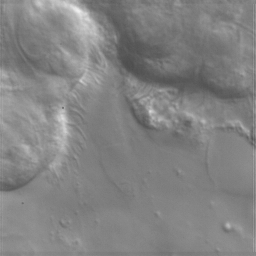

In [5]:
x3 = np.load("data/videos/stiff_dyskinetic.npy")
print("This video has {0} frames, and is {1} pixels tall and {2} pixels wide.".format(*x3.shape))
Image.fromarray(x3[0])

Those are the first frames of each of the three videos.

Our goal: to figure out how to highlight *just the cilia*. As you can tell, the cilia are tough to pick out!
 1. the hairs are thin and microscopic; not a lot of contrast to identify them
 2. there's a lot of noise (cells, background medium)
 3. drawing zones of cilia by hand is laborious, tedious, and highly subjective!

## Why not deep learn it?

Because of that pesky third point. We'd need some kind of "supervised" setup that requires a ground-truth.

And, well, someone has to create the ground truth somehow. More than likely, that will involve someone loading up a video and hand-drawing zones of cilia and not-cilia.

Yuck.

## Our Approach

We're going to try some fairly simple segmentation strategies to see if we can't stumble into a solution that "just works" without needing to "train" anything.

And we're going to use `ipywidgets` to help us!

## Validation

Of course, we do need a method to verify if our approaches are even remotely decent. So yes, I went ahead and created ground-truth segmentation masks for our three videos.

Here they are:

#### Normal

<IPython.core.display.Javascript object>


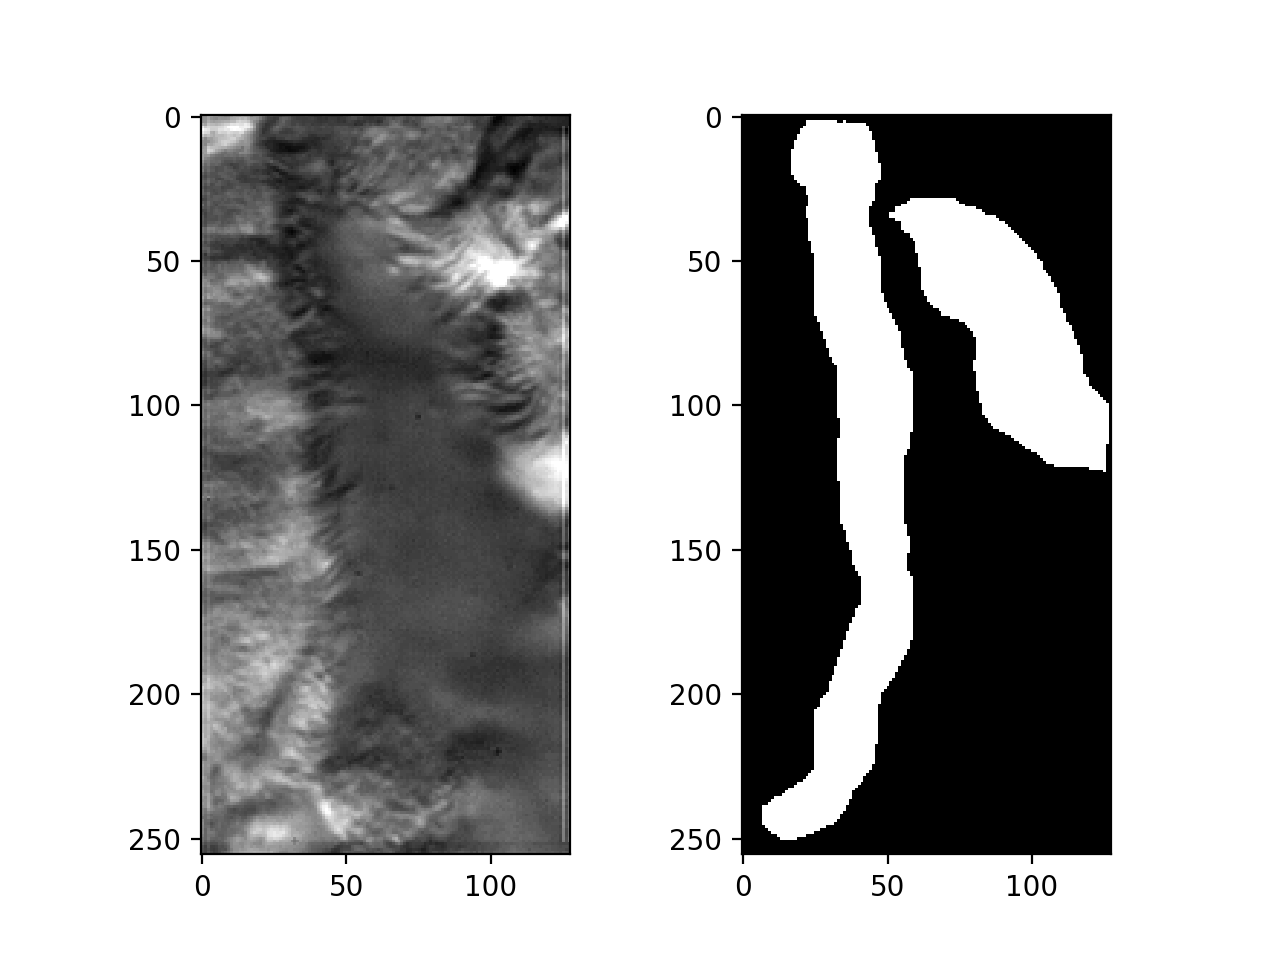

In [6]:
y1 = np.load("data/segmaps/normal_segmentation.npy")

# Visualize.
plt.subplot(1, 2, 1)
plt.imshow(x1[0], cmap = "gray")
plt.subplot(1, 2, 2)
plt.imshow(y1, cmap = "gray")

#### Wavy

<IPython.core.display.Javascript object>


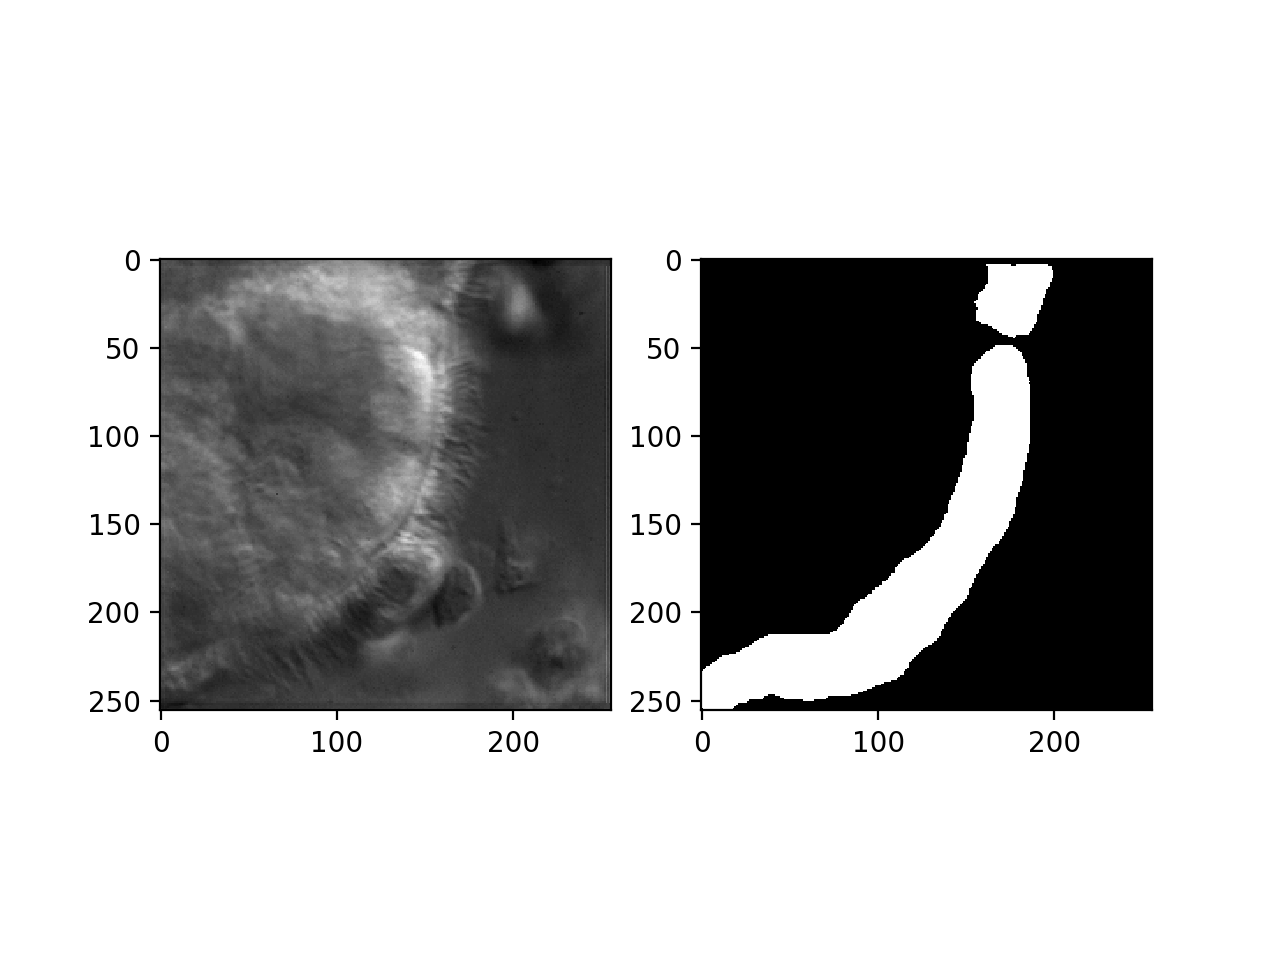

In [7]:
y2 = np.load("data/segmaps/wavy_segmentation.npy")

# Visualize.
plt.subplot(1, 2, 1)
plt.imshow(x2[0], cmap = "gray")
plt.subplot(1, 2, 2)
plt.imshow(y2, cmap = "gray")

#### Stiff / Dyskinetic

<IPython.core.display.Javascript object>


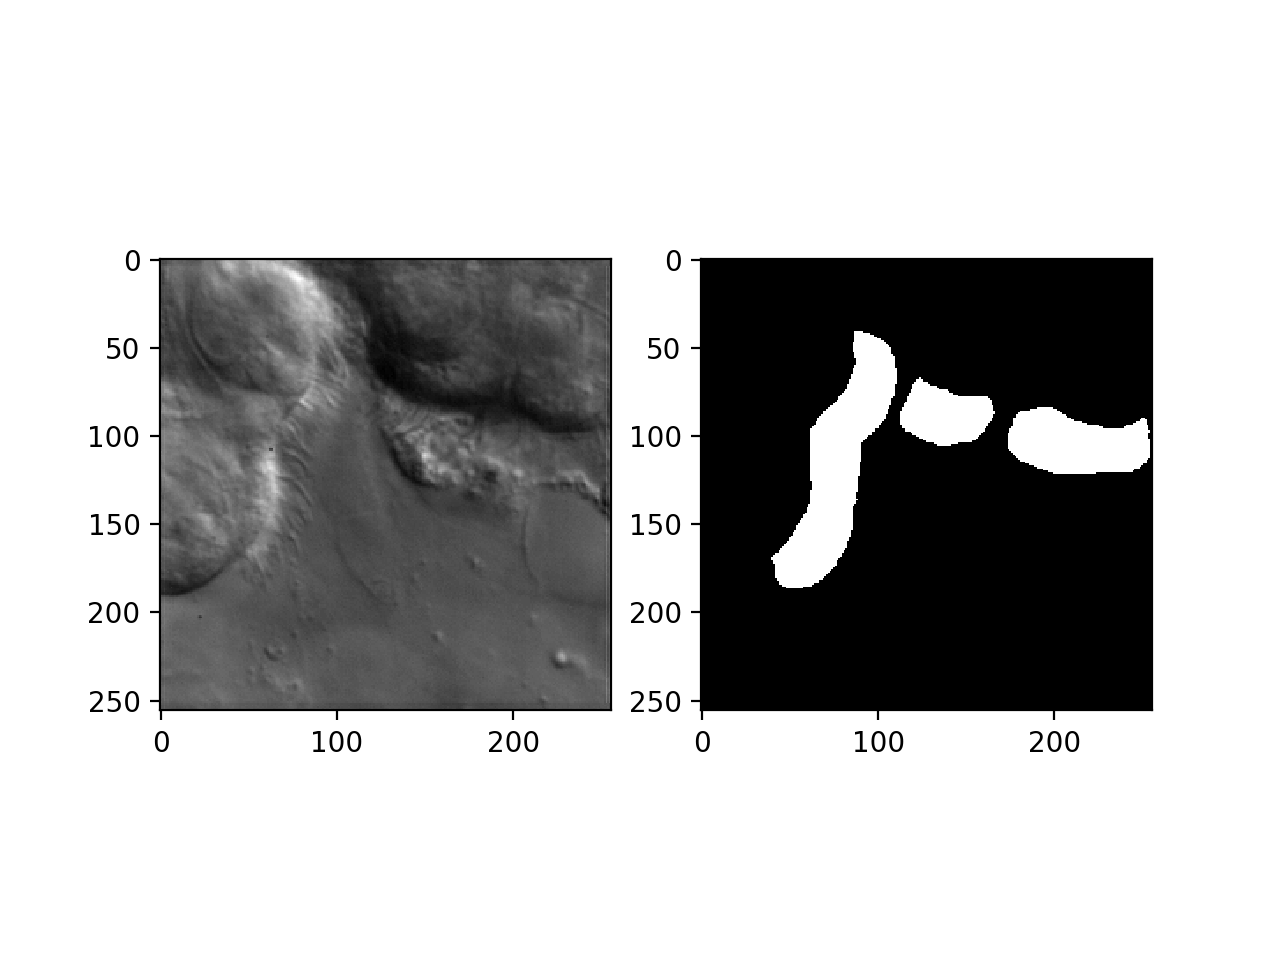

In [8]:
y3 = np.load("data/segmaps/stiff_segmentation.npy")

# Visualize.
plt.subplot(1, 2, 1)
plt.imshow(x3[0], cmap = "gray")
plt.subplot(1, 2, 2)
plt.imshow(y3, cmap = "gray")

## I don't buy those ground-truth masks

Fair enough. I drew those myself; nobody stood over my shoulder while I created them, or otherwise verified what I'd done.

How about we do that now? We can do so by way of our first look into `ipywidget`s!

## Sliders

The most basic `ipywidget` is the slider. It's like the scrubber button on any music track, video, or podcast; it allows you to select a particular value along a range of values.

We'll do that here to look at the frames of a video in sequence!

### Imagine...

Instead of pulling up VLC or whatever video player of choice, we want to scroll back and forth on the video from here in Jupyter.

It won't be a live video, but instead we'll get a picture of the current frame, and a scroll bar with the current frame number. We can then scroll along the slider, and get different frames of the video.

To do that, we'll need to define a `display_video` function that takes one of our NumPy video objects as input, and returns an `interact` object (hence our `from ipywidgets import interact` statement at the beginning).

`interact` has one required argument: a function callback for when the user (me) changes the value of the slider.

In [9]:
def display_video(video):
    n_frames = video.shape[0]
    
    # This is our callback function, and what makes the widget possible.
    def _show(frame = 1):
        return Image.fromarray(video[frame - 1])
    
    return interact(_show, frame = (1, n_frames))

In [10]:
display_video(x1[:50])

interactive(children=(IntSlider(value=1, description='frame', max=50, min=1), Output()), _dom_classes=('widget-interact',))

<function __main__.display_video.<locals>._show>

<IPython.core.display.Javascript object>


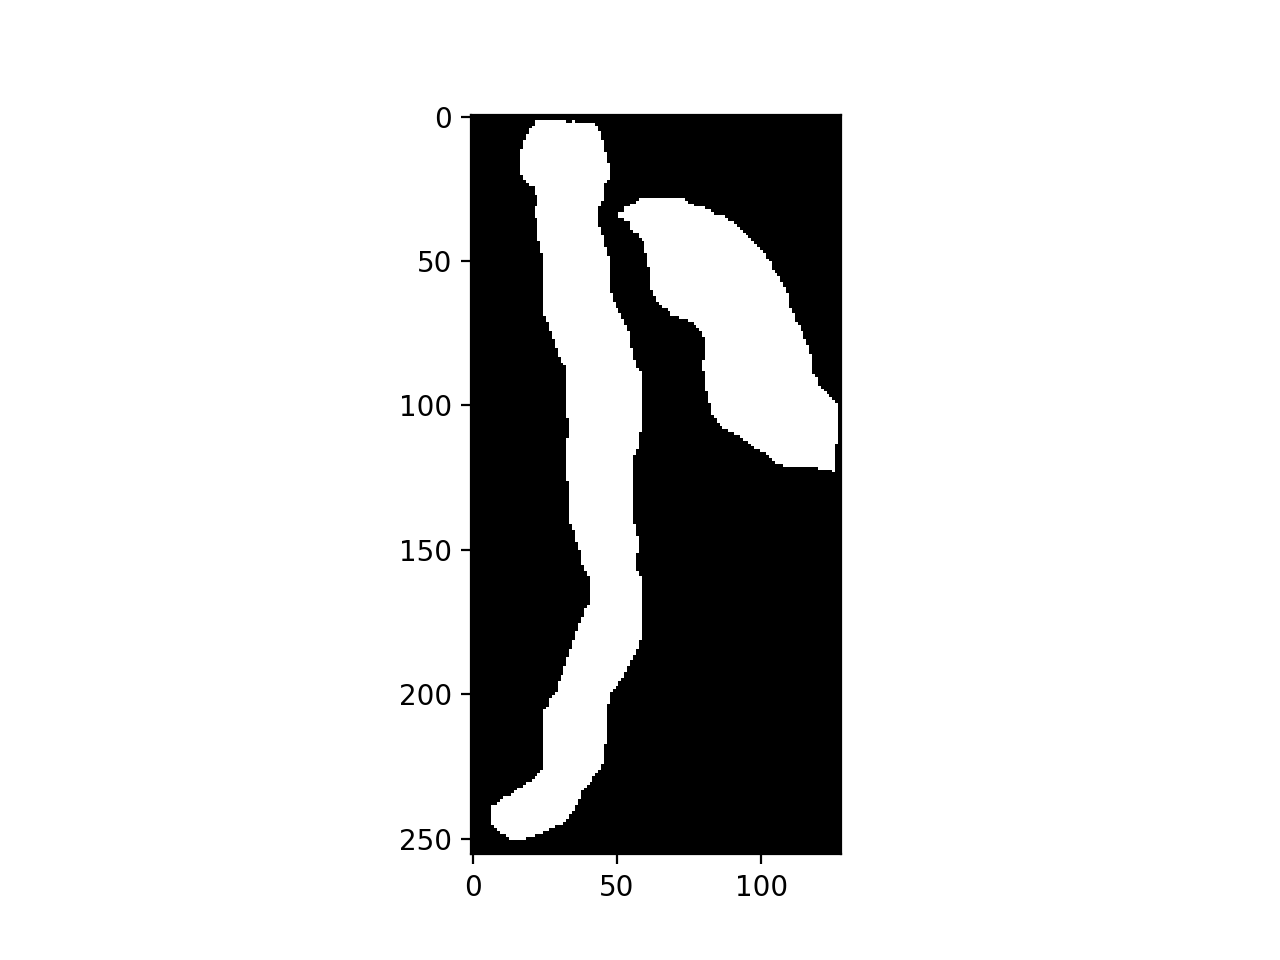

In [11]:
plt.imshow(y1, cmap = "gray")

In [12]:
display_video(x2[:50])

interactive(children=(IntSlider(value=1, description='frame', max=50, min=1), Output()), _dom_classes=('widget-interact',))

<function __main__.display_video.<locals>._show>

<IPython.core.display.Javascript object>


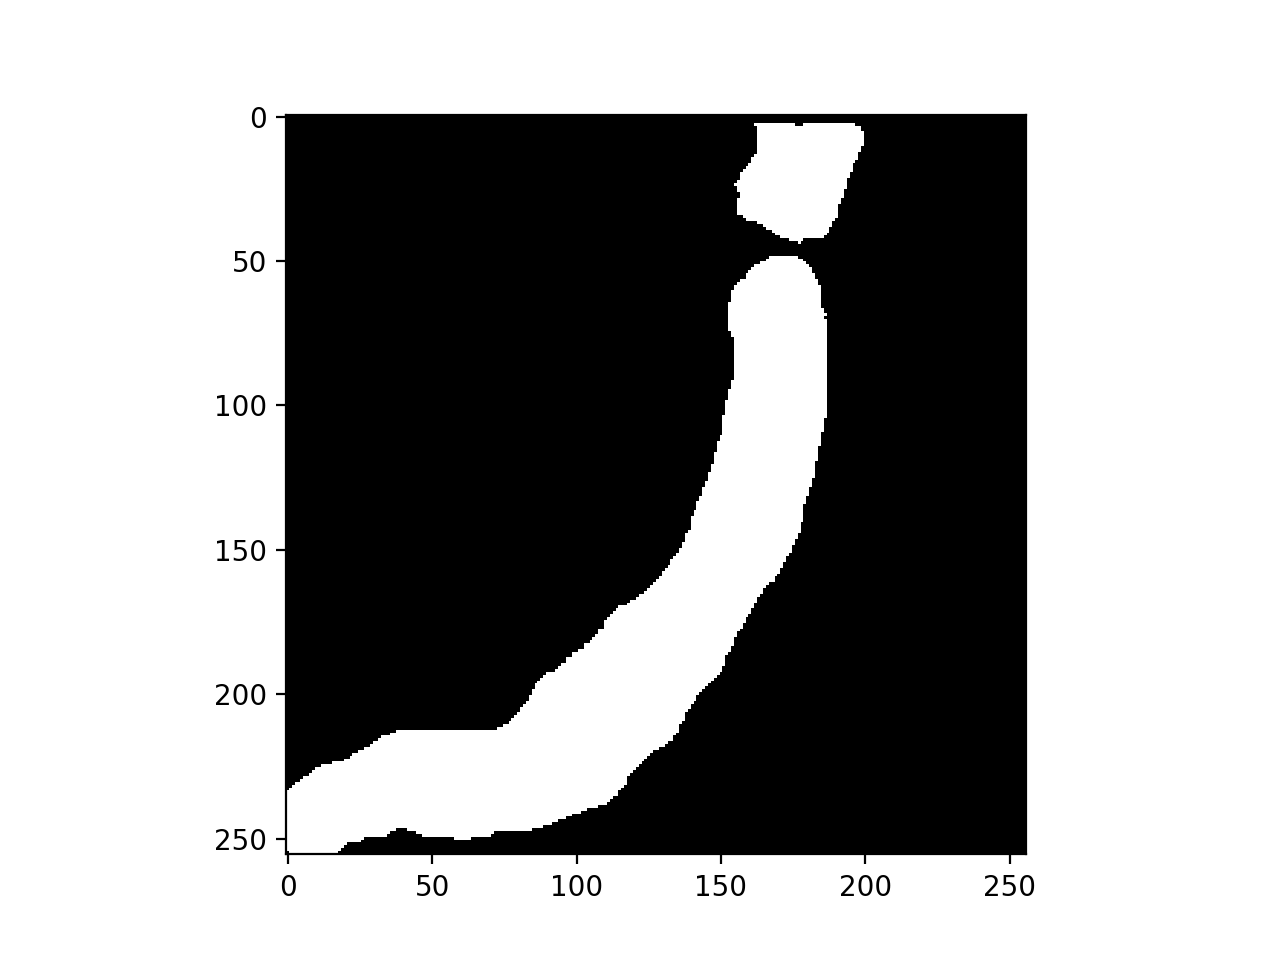

In [13]:
plt.imshow(y2, cmap = "gray")

In [14]:
display_video(x3[:50])

interactive(children=(IntSlider(value=1, description='frame', max=50, min=1), Output()), _dom_classes=('widget-interact',))

<function __main__.display_video.<locals>._show>

<IPython.core.display.Javascript object>


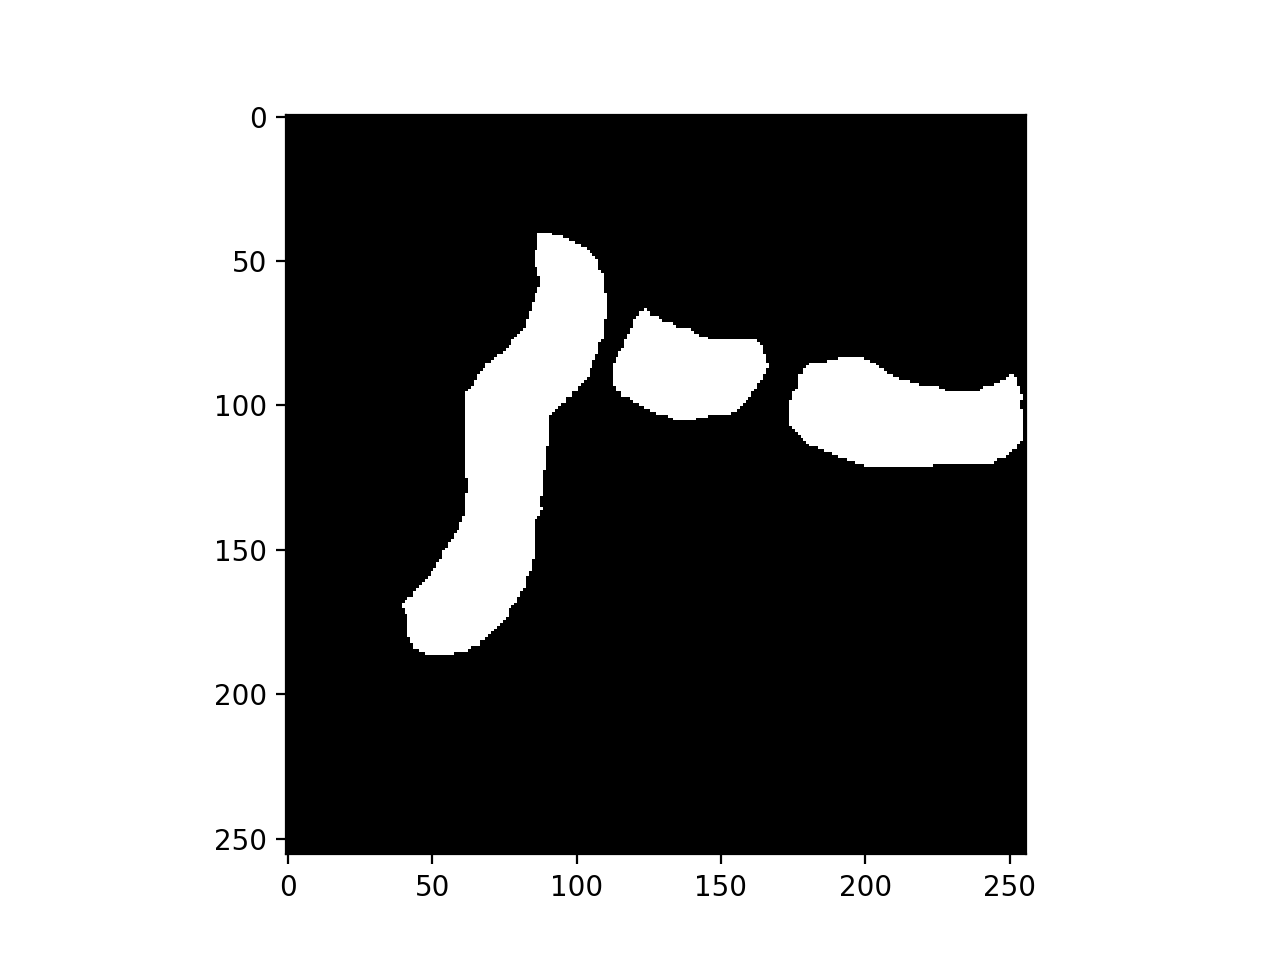

In [15]:
plt.imshow(y3, cmap = "gray")

## The `_show` function

It's the key to the whole thing.

(of course, you can call it whatever you want)

Whatever you put in that function is what happens when you change the slider--that function is handed the new value, and it tells Jupyter how to update the current picture.

With this example, it's pretty easy: just return the frame at the position in the video to match the index passed into the function.

```
def _show(frame = 1):
    return Image.fromarray(video[frame - 1])
```

The default argument is only used the very first time the function is called--when the cell is run for the first time. After that, it's passed whatever the slider changes to.

## The `interact` object

This packages the whole thing. The only *required* argument is the callback (which we named `_show`), but the optional arguments that follow allow you to determine all the *possible* values of the sliders.

```
return interact(_show, frame = (1, n_frames))
```

Since we specified `frame = (1, n_frames)`, that means the slider could go from 1 to whatever the value of `n_frames` was. We could have hard-coded it to 50 if we'd wanted, or anything else, and that would set the upper (right-hand side) limit of the slider.

You can add a third number in this tuple to enforce an increment rule. For example, 

```
return interact(_show, frame = (1, n_frames, 2))
```

would create slider values from 1 to 50 by twos (1, 3, 5, 7, etc). 

## Cool. What about this whole "segmentation" thing again?

The goal is to see if we can come up with a selection of pixels that closely matches the "ground-truth" masks.

We can evaluate how well we're doing using a metric called "intersection-over-union".

![iou](https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_examples.png)
Source: https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_examples.png

Basically: treat both regions as one and call that **union**, and put that into the denominator (to be precise, the number of pixels). Then, take only the region where the two overlap, and call that **intersection**. Put that in the numerator.

Voila-- *intersection over union*. If we get something close to 0, we're doing pretty badly; closer to 1, and we're doing well!

## Attempt 1: Find things that move

One way to look at videos is as *very high-dimensional time series*.

Check out an individual pixel:

<IPython.core.display.Javascript object>


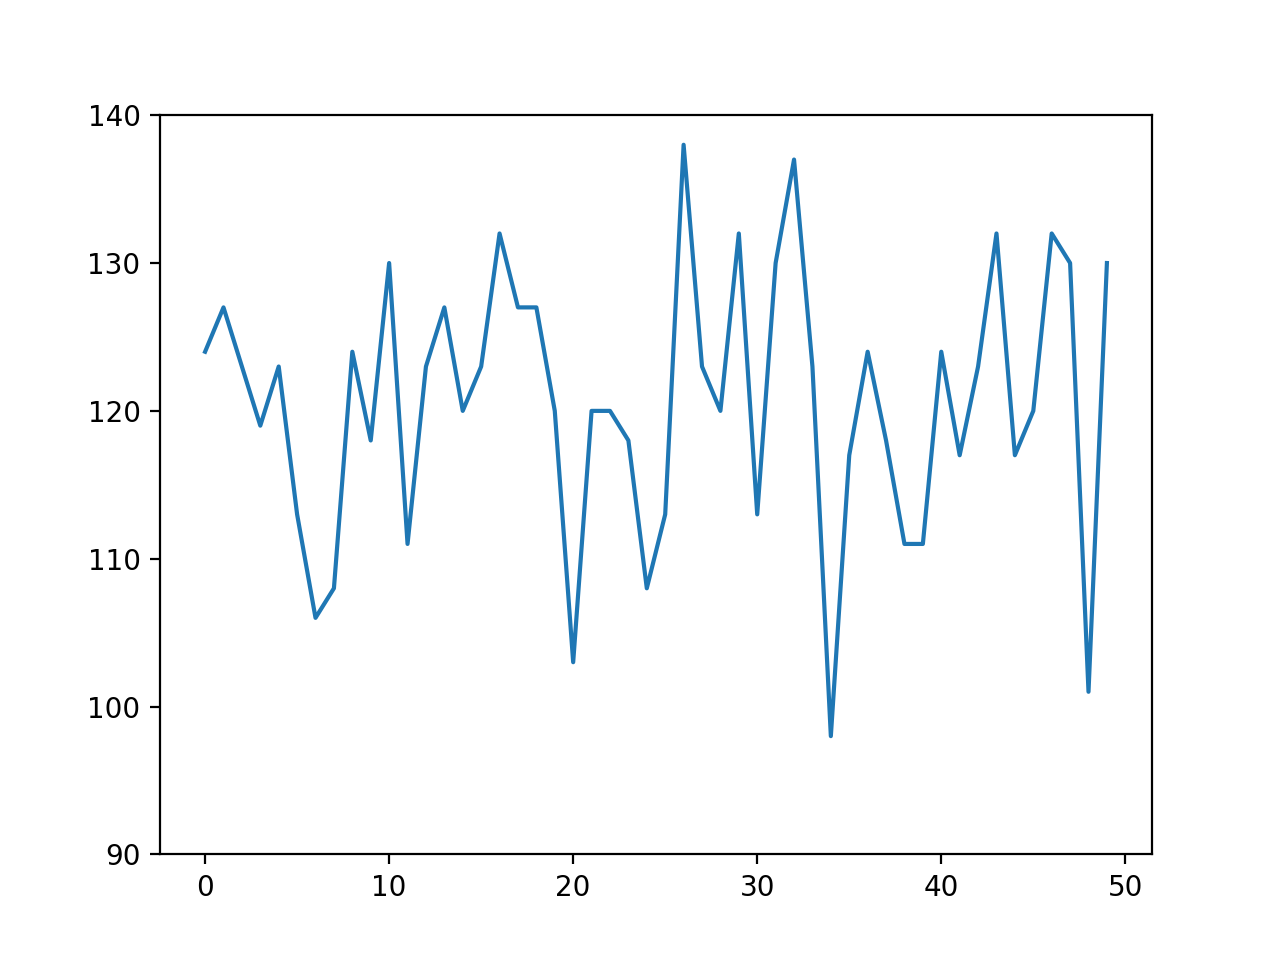

(90, 140)

In [16]:
plt.plot(x1[:50, 100, 50])
plt.ylim([90, 140])

This pixel has a mean and variance over those 50 frames:

In [17]:
print("Mean: {:.2f} ; Variance: {:.2f}".format(x1[:50, 150, 50].mean(), x1[:50, 150, 50].std()))

Mean: 131.04 ; Variance: 9.27


This pixel was explicitly chosen from within the "cilia" region. How about something out in the middle of nowhere?

<IPython.core.display.Javascript object>


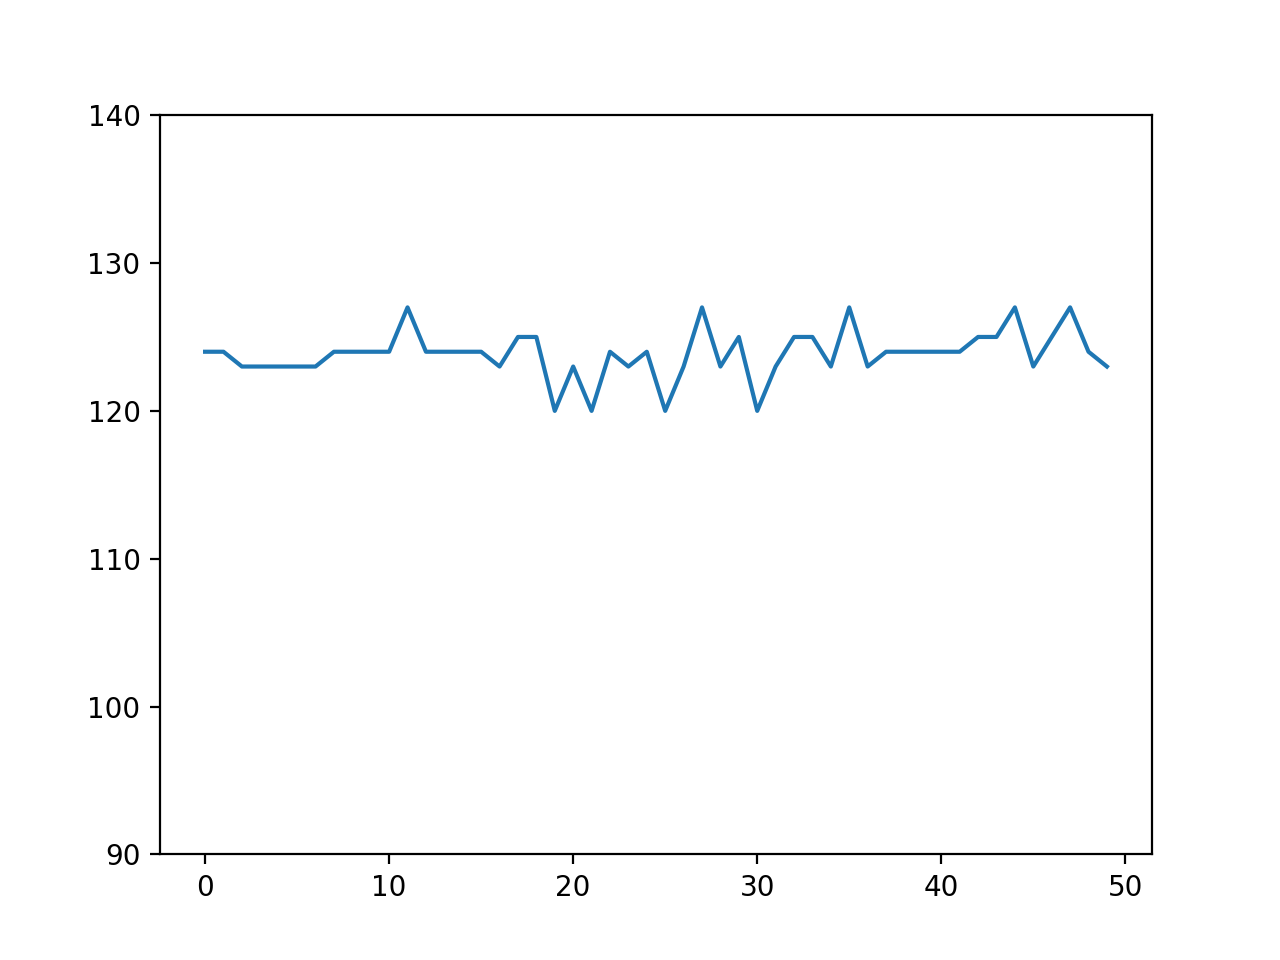

(90, 140)

In [18]:
plt.plot(x1[:50, 225, 75])
plt.ylim([90, 140])

In [19]:
print("Mean: {:.2f} ; Variance: {:.2f}".format(x1[:50, 225, 75].mean(), x1[:50, 225, 75].std()))

Mean: 123.84 ; Variance: 1.62


Mean isn't all that helpful, but check out the difference in variance--9.27 from a pixel near cilia, 1.62 from a pixel outside!

In fact, we kinda see something like this play out across the board.

<IPython.core.display.Javascript object>


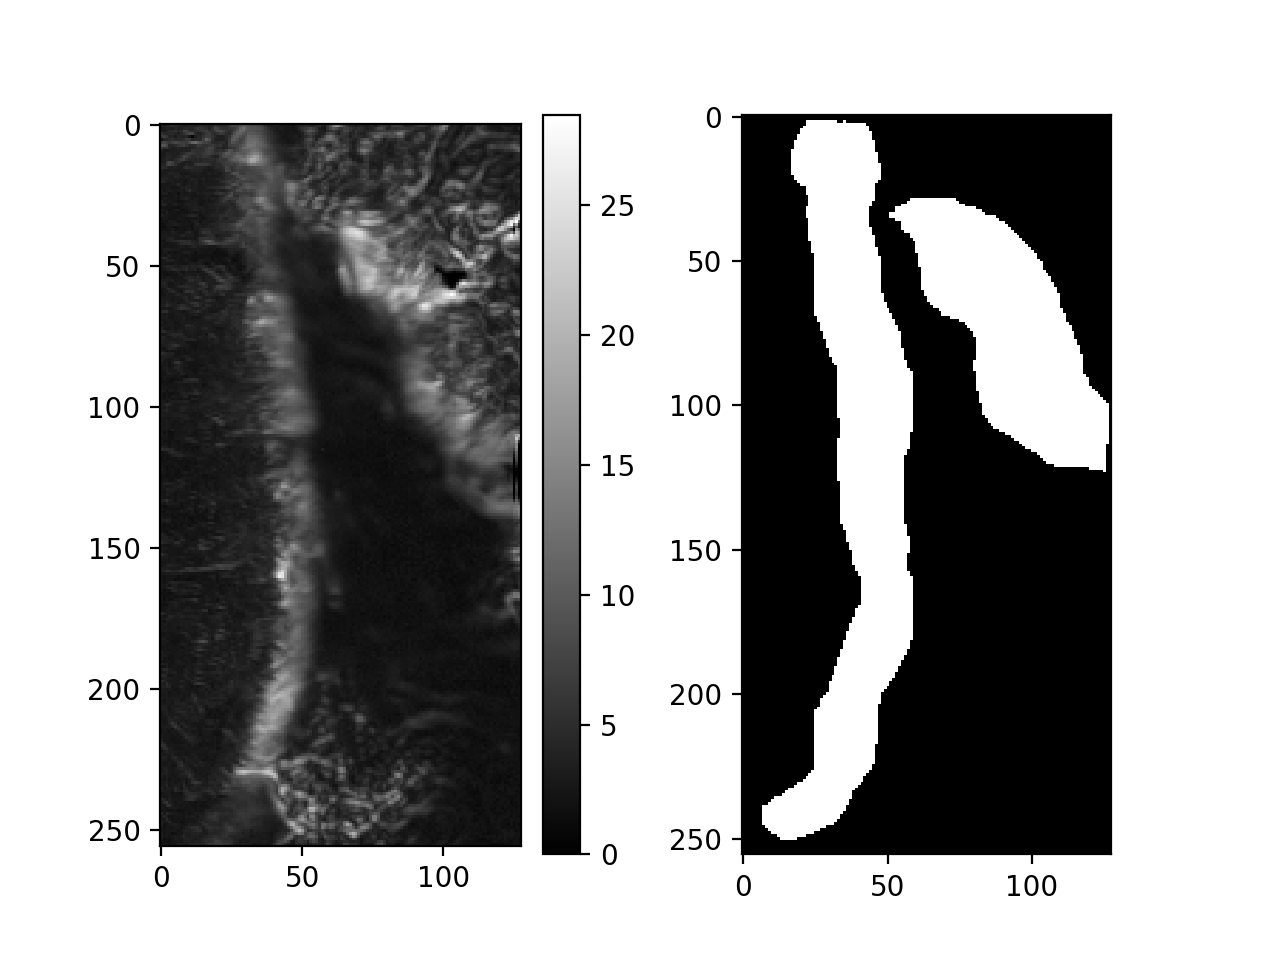

In [20]:
plt.subplot(1, 2, 1)
plt.imshow(x1.std(axis = 0), cmap = "gray")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(y1, cmap = "gray")

The regions with larger variances *seem* to group around the regions with cilia!

So we just need to pick pixels with a variance that's high.

...

Question: what qualifies as "high" variance?

## Ah, I see what you're getting at

Set up a widget to determine the variance threshold!

In [21]:
widgets.std_threshold(x1)

interactive(children=(FloatSlider(value=1.0, description='t', max=4.0), Output()), _dom_classes=('widget-interact',))

<function spq.widgets.std_threshold.<locals>._show>

Something around 1 seems pretty good!

(the slider actually represents *variance multiplier* thresholds--the value of the slider is multiplying the average pixel variance of the video, and using *that* as a threshold, where every pixel below that value is blackened)

In [22]:
widgets.std_threshold(x2)

interactive(children=(FloatSlider(value=1.0, description='t', max=4.0), Output()), _dom_classes=('widget-interact',))

<function spq.widgets.std_threshold.<locals>._show>

Something around 1.5 seems pretty good for this one.

In [23]:
widgets.std_threshold(x3)

interactive(children=(FloatSlider(value=1.0, description='t', max=4.0), Output()), _dom_classes=('widget-interact',))

<function spq.widgets.std_threshold.<locals>._show>

Something between 1.0 and 1.5 (1.3?) seems optimal.

Of course, we can go all out and parameter-scan against all three!

In [24]:
x = np.arange(0.0, 4.1, 0.1)

n_ious = np.zeros(shape = x.shape)
w_ious = np.zeros(shape = x.shape)
s_ious = np.zeros(shape = x.shape)

In [26]:
for i, threshold in enumerate(tqdm(x)):
    n_pred = utils.std(x1, threshold)
    w_pred = utils.std(x2, threshold)
    s_pred = utils.std(x3, threshold)
    
    n_ious[i] = evaluate.iou(n_pred, y1)
    w_ious[i] = evaluate.iou(w_pred, y2)
    s_ious[i] = evaluate.iou(s_pred, y3)

100%|██████████| 41/41 [00:06<00:00,  6.10it/s]


<IPython.core.display.Javascript object>


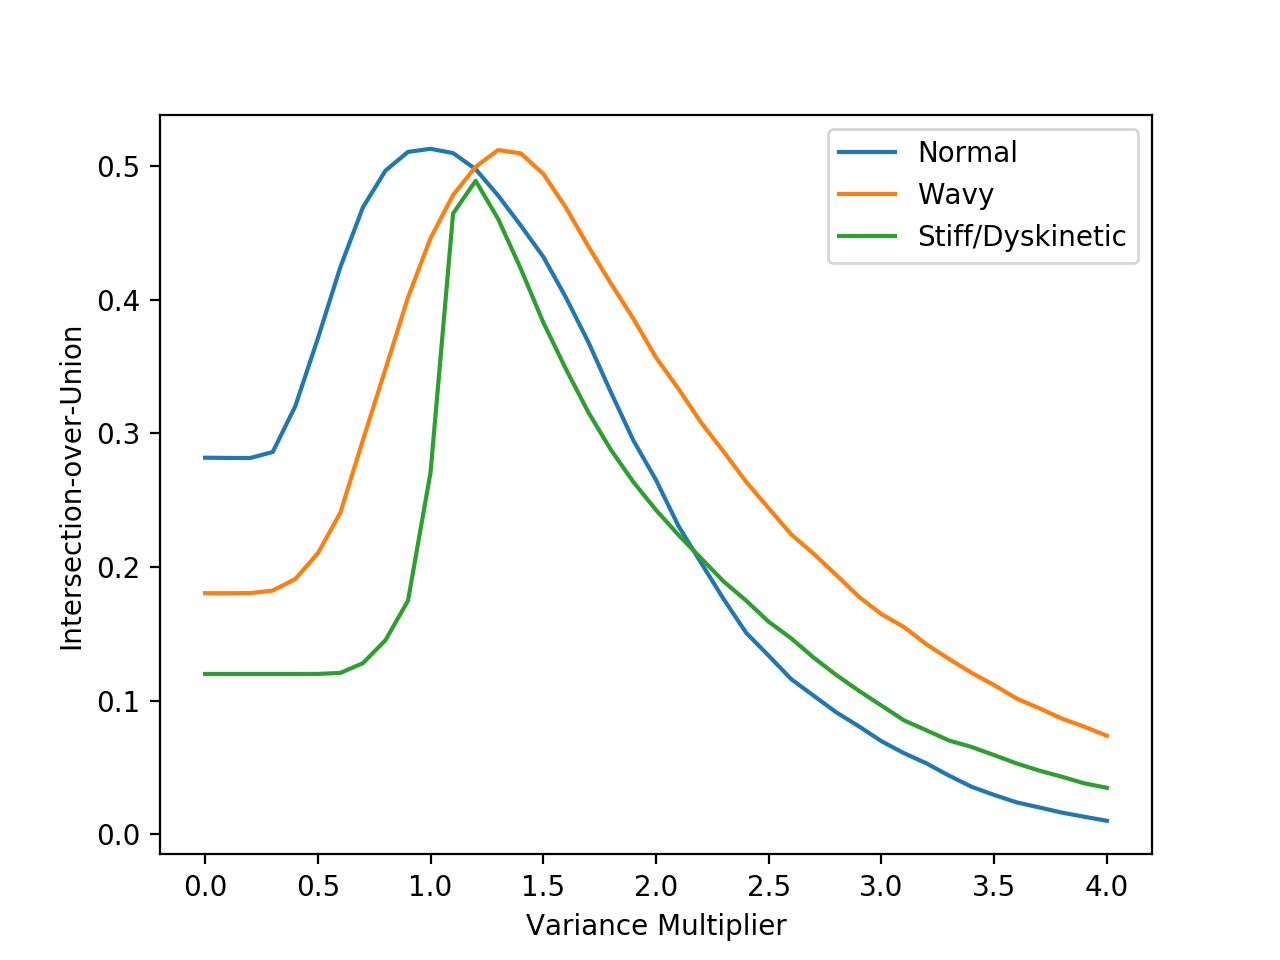

Text(0,0.5,'Intersection-over-Union')

In [27]:
plt.plot(x, n_ious, label = 'Normal')
plt.plot(x, w_ious, label = 'Wavy')
plt.plot(x, s_ious, label = 'Stiff/Dyskinetic')
plt.legend(loc = 0)
plt.xlabel("Variance Multiplier")
plt.ylabel("Intersection-over-Union")

Of course we could have just done this from the beginning, but the widgets gave us a really nice tactile interface to get a feel for how the matching evolved for each video.

## Attempt 2: Add more widgets!

Of course, you're not limited to simply one widget for any given cell. Simply by adding more parameters to the inner callback function, you can add more widgets. And there are more widgets than just sliders available!

We'll take our variance-threshold hack from before, but add in a twist: filtering. We'll run either an average or a median filter over our image of pixel variances *before* we set the threshold, hopefully smoothing out all the little pixel noise we saw before.

We'll also vary the size of the filter, from small (and not having much effect) to large (potentially washing out the image).

In the code, you'll see how we've changed our callback function:

```
def std_filter_threshold(video, multipliers = (0.0, 4.0, 0.1), filtersize = (1, 15, 2)):
    ...
    def _show(filter, multiplier = 1.0, filtersize = 3):
        ...
        return Image.fromarray(f)
    ...
    return interact(_show, filter = ["mean", "median"], multiplier = multipliers, filtersize = filtersize)
```

There are two key points here:
 1. The `filter` argument in the `return interact(...)` line contains a *list* of strings. That's how we tell ipywidgets what values to put in the drop-down menu (in this case, whether we're using a mean or median filter).
 2. The addition of new arguments to our callback function `_show`. One of them is the filter type, and the other two are the threshold multiplier and the size of the filter.
 
ipywidgets can see that there are 3 arguments, so it will render 3 different widgets for us!

In [28]:
widgets.std_filter_threshold(x1)

interactive(children=(Dropdown(description='filter', options=('mean', 'median'), value='mean'), FloatSlider(value=1.0, description='multiplier', max=4.0), IntSlider(value=3, description='filtersize', max=15, min=1, step=2), Output()), _dom_classes=('widget-interact',))

<function spq.widgets.std_filter_threshold.<locals>._show>

In [29]:
widgets.std_filter_threshold(x2)

interactive(children=(Dropdown(description='filter', options=('mean', 'median'), value='mean'), FloatSlider(value=1.0, description='multiplier', max=4.0), IntSlider(value=3, description='filtersize', max=15, min=1, step=2), Output()), _dom_classes=('widget-interact',))

<function spq.widgets.std_filter_threshold.<locals>._show>

In [30]:
widgets.std_filter_threshold(x3)

interactive(children=(Dropdown(description='filter', options=('mean', 'median'), value='mean'), FloatSlider(value=1.0, description='multiplier', max=4.0), IntSlider(value=3, description='filtersize', max=15, min=1, step=2), Output()), _dom_classes=('widget-interact',))

<function spq.widgets.std_filter_threshold.<locals>._show>

In [31]:
x = np.arange(0.0, 4.1, 0.1)

n_ious = np.zeros(shape = x.shape)
w_ious = np.zeros(shape = x.shape)
s_ious = np.zeros(shape = x.shape)

In [32]:
for i, threshold in enumerate(tqdm(x)):
    n_pred = utils.std_filter(x1, threshold, "median", 15)
    w_pred = utils.std_filter(x2, threshold, "median", 15)
    s_pred = utils.std_filter(x3, threshold, "mean", 9)
    
    n_ious[i] = evaluate.iou(n_pred, y1)
    w_ious[i] = evaluate.iou(w_pred, y2)
    s_ious[i] = evaluate.iou(s_pred, y3)

100%|██████████| 41/41 [00:15<00:00,  2.68it/s]


<IPython.core.display.Javascript object>


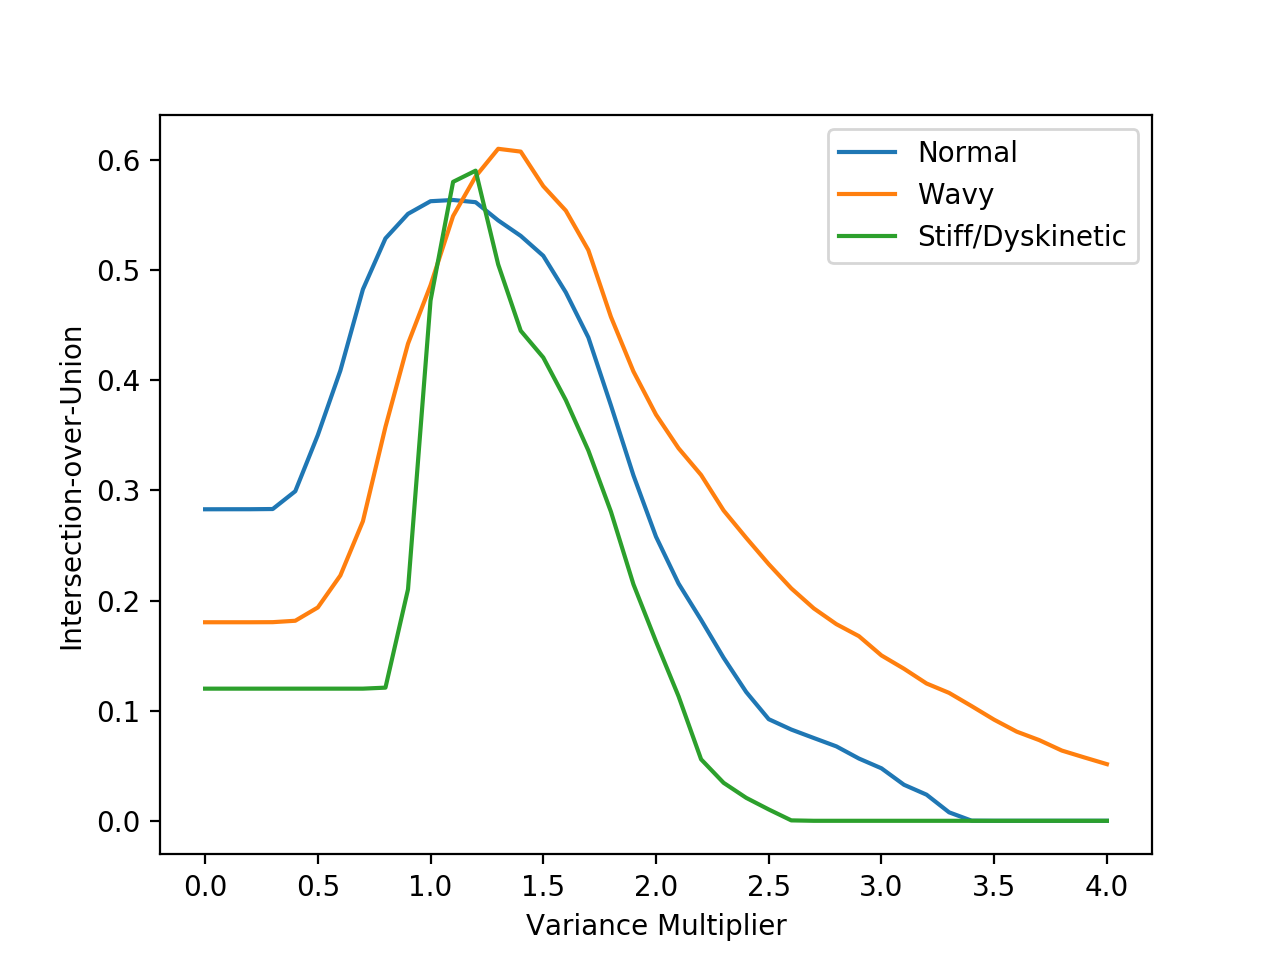

Text(0,0.5,'Intersection-over-Union')

In [33]:
plt.plot(x, n_ious, label = 'Normal')
plt.plot(x, w_ious, label = 'Wavy')
plt.plot(x, s_ious, label = 'Stiff/Dyskinetic')
plt.legend(loc = 0)
plt.xlabel("Variance Multiplier")
plt.ylabel("Intersection-over-Union")

We did a lot better! Nothing was over 0.5 before; now, everything is.

## Concluding Thoughts

 - Supervised segmentation is hard enough without worrying if your ground-truth is wrong. Problem is, coming up with fully-autonomous segmentation methods isn't that much easier.
 
 - It all gets even harder when we're not segmenting actual objects, but instead lots of little flexible things that move.

 - `ipywidgets` are incredibly helpful for data exploration and "getting a feel" for your methods.
 
 - Natural fit with Jupyter notebooks, which also make data exploration easy.

## References

#### `ipywidgets`: https://ipywidgets.readthedocs.io/ 

We've barely scratched the surface of what ipywidgets can do--you can exert a lot more fine-grained control over the types of widgets and how they behave.

Jake VanderPlas had another great example of using ipywidgets in Jupyter notebooks: https://jakevdp.github.io/blog/2017/12/11/live-coding-cython-ising-model/

#### `tqdm`: https://pypi.python.org/pypi/tqdm

A really nice and lightweight progress bar for looping over Python collections.

#### Image filters

Here's the median filter we used, from SciPy's `signal` submodule: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.medfilt2d.html#scipy.signal.medfilt2d

Here's the mean filter we used, from SciPy's `ndimage` submodule:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html#scipy.ndimage.gaussian_filter

#### Cilia (and other open biomedical imaging research)

Come talk to me! I'm always looking for highly motivated students to help me out.

 - Twitter: [@SpectralFilter](https://twitter.com/SpectralFilter)
 - Email: [spq@uga.edu](mailto:spq@uga.edu)
 - Lab site: [Quinn Research Group](https://quinngroup.github.io)

<img src="https://quinngroup.github.io/images/people/quinn.png" align="left" width="25%" />

# THANK YOU!